**Mounting google drive to download the dataset**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**Importing Modules and library needed**

In [ ]:
import numpy as np
from tensorflow import keras
from matplotlib import pyplot as plt

**Downloading dataset (32x32 inpainted image and its mask)**

In [ ]:
masks_32x32x3 = np.load('/content/drive/MyDrive/Machine Learning data/9600 Images/output_mask.npy')
inpainted_images_32x32x3 = np.load('/content/drive/MyDrive/Machine Learning data/9600 Images/output_inpainted_image.npy')

**Display inpainted image and its mask from the dataset**

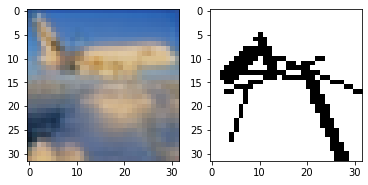

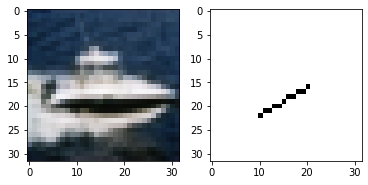

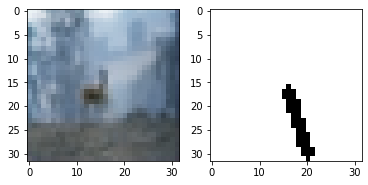

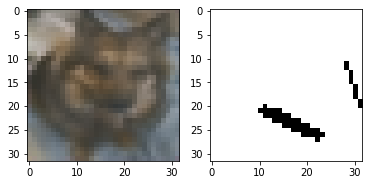

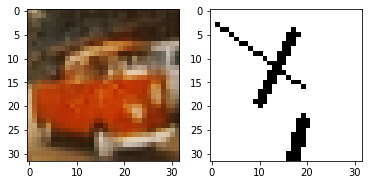

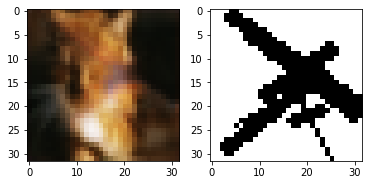

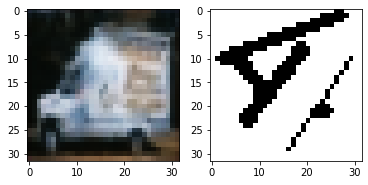

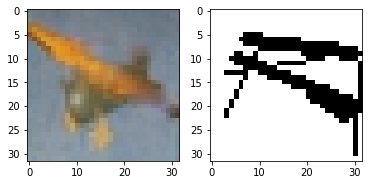

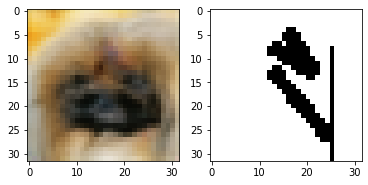

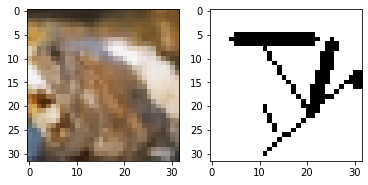

In [ ]:
def display_dataset(inpained_images, masks):
  for i in range(10):
      f = plt.figure()
      f.add_subplot(1,2, 1)
      # Display the inpainted image
      plt.imshow(inpained_images[i], cmap='gray')
      f.add_subplot(1,2, 2)
      # Display its corresponding mask
      plt.imshow(masks[i], cmap='gray')
      plt.show(block=True)

display_dataset(inpainted_images_32x32x3, masks_32x32x3)

**Declaring some useful variables**

In [ ]:
inpainted_image_size = (32, 32, 3)
num_classes = 2
batch_size = 1

**Method to change shape of mask from (32,32,3) to (32,32,1)**

In [ ]:
def change_mask_shape(masks_32x32x3):
  masks_32x32x1 = []
  for i in range(len(masks_32x32x3)):
    temp1 = []
    for j in range(32):
      temp2 = []
      for k in range(32):
        if masks_32x32x3[i][j][k][0] == 0:
          temp2.append([0])
        else:
          temp2.append([1])
      temp1.append(temp2)
    masks_32x32x1.append(temp1)
  return masks_32x32x1

masks_32x32x1_list = change_mask_shape(masks_32x32x3)
masks_32x32x1 = np.asarray(masks_32x32x1_list);

**Method to divide the dataset into the batch size**

In [ ]:
class Batching_Dataset(keras.utils.Sequence):
    """Helper to iterate over the data (as Numpy arrays)."""

    def __init__(self, batch_size, inpainted_images, masks):
        self.batch_size = batch_size
        self.inpainted_images = inpainted_images
        self.masks = masks

    def __len__(self):
        return len(self.masks) // self.batch_size

    def __getitem__(self, idx):
        """Returns tuple (input, target) correspond to batch #idx."""
        i = idx * self.batch_size
        batch_inpainted_images = self.inpainted_images[i : i + self.batch_size]
        batch_masks = self.masks[i : i + self.batch_size]
        return batch_masks, batch_inpainted_images

**U-net Model for Binary Image Segmentation**

In [ ]:
import tensorflow as tf


def get_model(img_size, num_classes):
    inputs = tf.keras.layers.Input(img_size)

    #Downscaling dataset
    c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(inputs)
    p1 = tf.keras.layers.MaxPooling2D((2, 2))(c1)

    c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
    p2 = tf.keras.layers.MaxPooling2D((2, 2))(c2)
    
    c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
    p3 = tf.keras.layers.MaxPooling2D((2, 2))(c3)
    
    c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
    p4 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(c4)
    
    c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)

    #Upscaling dataset
    u6 = tf.keras.layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = tf.keras.layers.concatenate([u6, c4])
    c6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
    
    u7 = tf.keras.layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = tf.keras.layers.concatenate([u7, c3])
    c7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
    
    u8 = tf.keras.layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = tf.keras.layers.concatenate([u8, c2])
    c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
    
    u9 = tf.keras.layers.Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = tf.keras.layers.concatenate([u9, c1], axis=3)
    c9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
    
    outputs = tf.keras.layers.Conv2D(1, (1, 1), activation='sigmoid')(c9)
    
    model = tf.keras.Model(inputs=[inputs], outputs=[outputs])
    return model
    
keras.backend.clear_session()

# Build model
model = get_model(inpainted_image_size, num_classes)
model.summary()

    

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 32, 32, 16)   448         input_1[0][0]                    
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 16, 16, 16)   0           conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 16, 16, 32)   4640        max_pooling2d[0][0]              
______________________________________________________________________________________________

**Dividing the dataset into training data and validation data**

In [ ]:
# Split our dataset into a training and a validation set
val_samples = 2600

# Instantiate data Sequences for each split
train_gen = Batching_Dataset(batch_size, masks_32x32x1[:-val_samples], inpainted_images_32x32x3[:-val_samples])
val_gen = Batching_Dataset(batch_size, masks_32x32x1[-val_samples:], inpainted_images_32x32x3[-val_samples:])

**Training Model**

In [ ]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model, doing validation at the end of each epoch.
epochs = 25
history = model.fit(train_gen, epochs=epochs, validation_data=val_gen)

Epoch 1/25
7000/7000 [==============================] - 86s 8ms/step - loss: 0.4015 - accuracy: 0.8453 - val_loss: 0.3501 - val_accuracy: 0.8663
Epoch 2/25
7000/7000 [==============================] - 53s 8ms/step - loss: 0.3299 - accuracy: 0.8763 - val_loss: 0.2783 - val_accuracy: 0.8980
Epoch 3/25
7000/7000 [==============================] - 54s 8ms/step - loss: 0.2677 - accuracy: 0.9014 - val_loss: 0.2415 - val_accuracy: 0.9100
Epoch 4/25
7000/7000 [==============================] - 55s 8ms/step - loss: 0.2388 - accuracy: 0.9110 - val_loss: 0.2208 - val_accuracy: 0.9168
Epoch 5/25
7000/7000 [==============================] - 56s 8ms/step - loss: 0.2214 - accuracy: 0.9168 - val_loss: 0.2165 - val_accuracy: 0.9177
Epoch 6/25
7000/7000 [==============================] - 55s 8ms/step - loss: 0.2079 - accuracy: 0.9211 - val_loss: 0.2035 - val_accuracy: 0.9229
Epoch 7/25
7000/7000 [==============================] - 53s 8ms/step - loss: 0.2019 - accuracy: 0.9229 - val_loss: 0.1962 - val_ac

**Method to display the mask**

In [ ]:
def return_mask(mask_32x32x1):
  output_mask_list = []
  for i in range(32):
    temp = []
    for j in range(32):
      if mask_32x32x1[i][j][0] < 0.4:
        temp.append([0.,0.,0.])
      elif mask_32x32x1[i][j][0] > 0.8:
        temp.append([1.,1.,1.])
      else:
        temp.append([0.5,0.5,0.5])
    output_mask_list.append(temp)
  output_mask = np.asarray(output_mask_list)
  return output_mask 

**Method to Visualise Prediction**

In [ ]:
def visualise_prediction(index, base):
  for i in range(10):
    # Generate predictions for all images in the validation set
    prediction  = model.predict(val_gen)
    # Display prediction result for 10 images
    predicted_mask = return_mask(prediction[index+i])
    ground_truth_mask = return_mask(masks_32x32x1[base+index+i])
    f = plt.figure()
    f.add_subplot(1,3, 1)
    # Display mask predicted by our model
    plt.imshow(predicted_mask, cmap='gray')
    f.add_subplot(1,3, 2)
    # Display ground-truth target mask
    plt.imshow(ground_truth_mask, cmap='gray')
    f.add_subplot(1,3, 3)
    # Display input image
    plt.imshow(inpainted_images_32x32x3[base+index+i], cmap='gray')
    plt.show(block=True)

**Visualise Prediction**

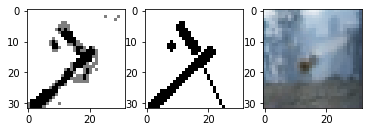

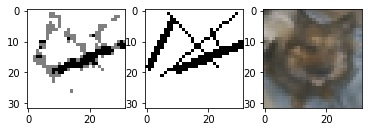

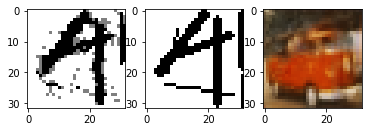

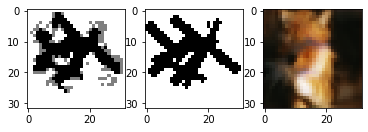

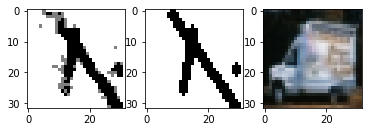

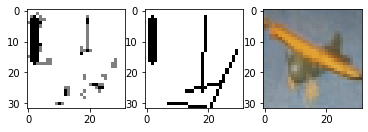

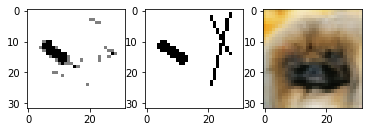

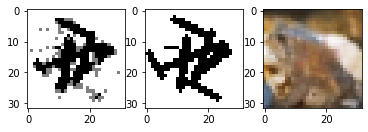

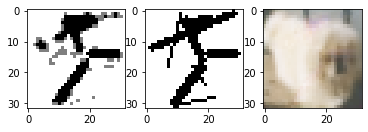

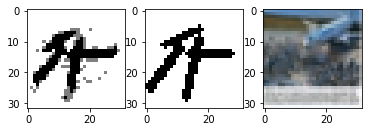

In [ ]:
visualise_prediction(10,7000)

**List all data in history**

In [ ]:
print(history.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


**Summarize history for accuracy**

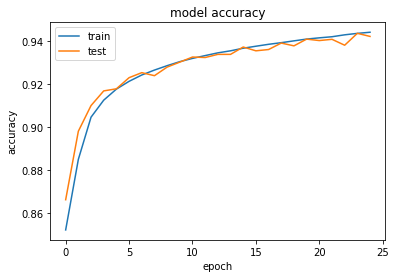

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

**Summarize history for loss**

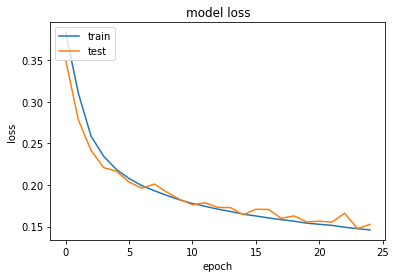

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()